In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import shap
import joblib
from scipy.stats import randint, uniform

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
df = pd.read_csv('../data/final_model_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Create derived features
# High-Low Range
df['HL_Range'] = (df['High'] - df['Low']) / df['Close']

# Group by ticker to avoid lookahead bias when calculating changes
for ticker in df['Ticker'].unique():
    mask = df['Ticker'] == ticker
    # Volume change
    df.loc[mask, 'Volume_1d_chg'] = df.loc[mask, 'Volume'].pct_change()
    # Price change
    df.loc[mask, 'Price_1d_chg'] = df.loc[mask, 'Close'].pct_change()

# Fill NaN values created by pct_change()
df['Volume_1d_chg'] = df['Volume_1d_chg'].fillna(0)
df['Price_1d_chg'] = df['Price_1d_chg'].fillna(0)

print(f"Loaded data with shape: {df.shape}")
print("\nColumns available:", ', '.join(df.columns))
print("\nDerived features created:", ['HL_Range', 'Volume_1d_chg', 'Price_1d_chg'])


Loaded data with shape: (3762, 21)

Columns available: Date, Open, High, Low, Close, Volume, Dividends, Stock splits, Ticker, EMA10, EMA50, RSI, MACD, MACD_Signal, MACD_Hist, future_return, Signal, y, HL_Range, Volume_1d_chg, Price_1d_chg

Derived features created: ['HL_Range', 'Volume_1d_chg', 'Price_1d_chg']


C:\Users\techs\AppData\Local\Temp\ipykernel_149432\2014709484.py:19: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


In [12]:
# Define feature sets and prepare data
feature_columns = [
    # Technical Indicators
    'RSI',
    'EMA10',
    'EMA50',
    'MACD',
    'MACD_Signal',
    'MACD_Hist',
    
    # Price and Volume
    'Volume',
    'Close',
    'High',
    'Low',
    
    # Derived Features
    'HL_Range',
    'Volume_1d_chg',
    'Price_1d_chg',
    'future_return'
]

# Prepare features (X) and target (y)
X = df[feature_columns].copy()
y = df['y'].copy()  # Using numerical labels (-1, 0, 1)

# Transform labels from [-1, 0, 1] to [0, 1, 2] for XGBoost
y = y.map({-1: 0, 0: 1, 1: 2})

# Handle missing values
X = X.fillna(method='ffill')
X = X.fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Perform chronological split
split_idx = int(len(X) * 0.8)
X_train = X_scaled.iloc[:split_idx]
X_test = X_scaled.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True).round(3))
print("\nClass mapping:")
print("0 (was -1): Sell")
print("1 (was 0): Hold")
print("2 (was 1): Buy")



Training set shape: (3009, 14)
Test set shape: (753, 14)

Class distribution in training set:
y
1    0.427
2    0.309
0    0.264
Name: proportion, dtype: float64

Class mapping:
0 (was -1): Sell
1 (was 0): Hold
2 (was 1): Buy


C:\Users\techs\AppData\Local\Temp\ipykernel_149432\3944012293.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill')


In [15]:
# Define parameter grid for RandomizedSearchCV
param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'min_child_weight': randint(1, 7)
}

# Create base model
base_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    scale_pos_weight='balanced',
    random_state=42
)

# Create TimeSeriesSplit for validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='balanced_accuracy',
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print("Starting hyperparameter tuning...")
# Fit without early stopping during cross-validation
random_search.fit(X_train, y_train)

# After finding best parameters, we'll use early stopping in the final model

print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")


Starting hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\techs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [18:23:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found:
colsample_bytree: 0.8073318609454947
gamma: 0.4386865359639777
learning_rate: 0.23223058532626134
max_depth: 3
min_child_weight: 1
n_estimators: 398
subsample: 0.8835643987640474

Best cross-validation score: 0.996


C:\Users\techs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [18:23:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "early_stopping", "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
              precision    recall  f1-score   support

    Sell (0)       1.00      1.00      1.00       198
    Hold (1)       0.99      1.00      1.00       346
     Buy (2)       1.00      0.99      0.99       209

    accuracy                           1.00       753
   macro avg       1.00      1.00      1.00       753
weighted avg       1.00      1.00      1.00       753



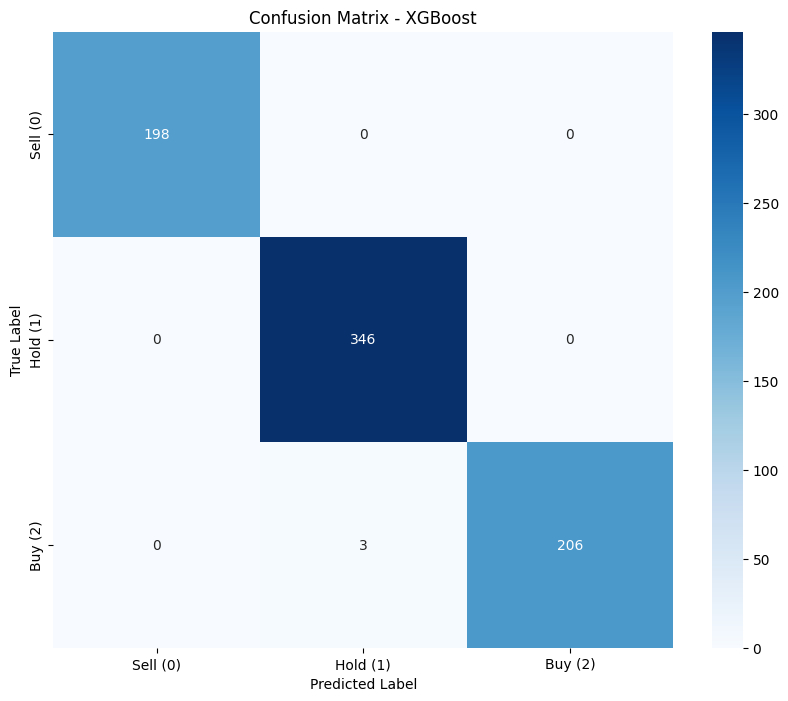

In [17]:
# Train final model with best parameters
best_model = xgb.XGBClassifier(
    **random_search.best_params_,
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    scale_pos_weight='balanced',
    random_state=42,
    early_stopping=10,  # Correct parameter name for early stopping
    eval_metric=['merror', 'mlogloss']  # Multiple evaluation metrics
)

# Create a validation set for early stopping (10% of training data)
valid_size = int(len(X_train) * 0.1)
X_train_final = X_train[:-valid_size]
X_valid = X_train[-valid_size:]
y_train_final = y_train[:-valid_size]
y_valid = y_train[-valid_size:]

# Fit the model with early stopping
best_model.fit(
    X_train_final, 
    y_train_final,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

# Make predictions
y_pred = best_model.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Sell (0)', 'Hold (1)', 'Buy (2)']))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sell (0)', 'Hold (1)', 'Buy (2)'],
            yticklabels=['Sell (0)', 'Hold (1)', 'Buy (2)'])
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


<Figure size 1200x600 with 0 Axes>

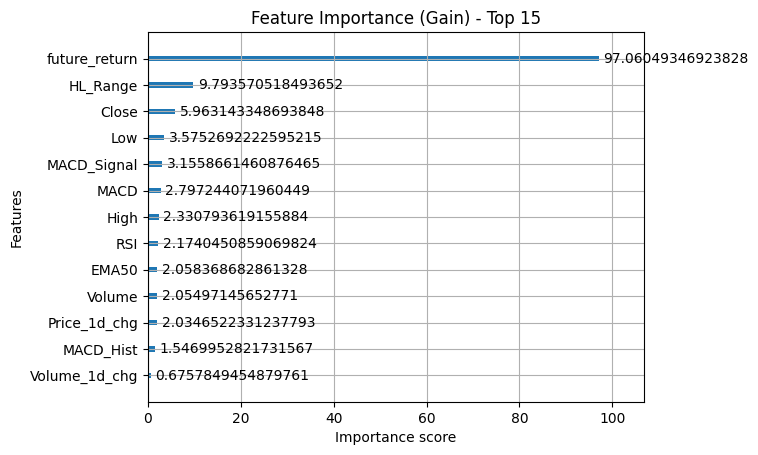


Top 10 Most Important Features:
          feature  importance
13  future_return    0.717791
10       HL_Range    0.072426
7           Close    0.044099
9             Low    0.026440
4     MACD_Signal    0.023339
3            MACD    0.020686
8            High    0.017237
0             RSI    0.016078
2           EMA50    0.015222
6          Volume    0.015197


In [18]:
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(best_model, max_num_features=15, importance_type='gain')
plt.title('Feature Importance (Gain) - Top 15')
plt.show()

# Calculate and display feature importance scores
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))


Calculating SHAP values...


C:\Users\techs\AppData\Local\Temp\ipykernel_149432\1426086796.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
C:\Users\techs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
C:\Users\techs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by ca

<Figure size 1200x800 with 0 Axes>

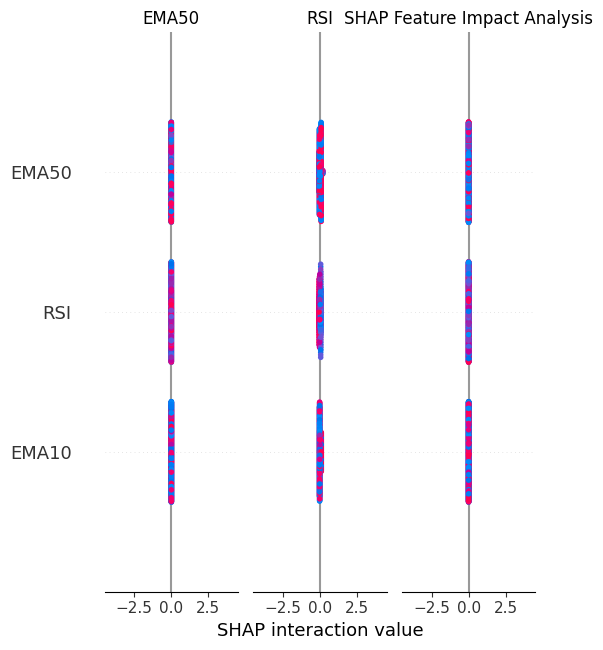


Saved model to: ../models/xgb_model.pkl
Saved feature scaler to: ../models/feature_scaler.pkl


In [19]:
# SHAP value analysis
print("Calculating SHAP values...")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title('SHAP Feature Impact Analysis')
plt.tight_layout()
plt.show()

# Save the model
model_path = '../models/xgb_model.pkl'
joblib.dump(best_model, model_path)
print(f"\nSaved model to: {model_path}")

# Save feature scaler for future use
scaler_path = '../models/feature_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Saved feature scaler to: {scaler_path}")
